In [86]:
import numpy as np
import pyfits
import math
from math import log10
import matplotlib.pyplot as plt
import scipy
from scipy.stats import binned_statistic
from scipy.stats import binned_statistic_2d
from matplotlib import rc
import pickle
import os
import astropy as ap
from astropy.cosmology import WMAP7
from scipy import interpolate
import corner
import matplotlib.patheffects as patheffects
from matplotlib import rcParams
from matplotlib.path import Path
import matplotlib.patches as patches
import matplotlib as mpl
from matplotlib import rc
from matplotlib import colors
from __future__ import unicode_literals
# rcParams["font.size"] = 16
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Computer Modern Sans"]
rcParams["text.usetex"] = True
rcParams["text.latex.preamble"] = r"\usepackage{cmbright}"

rcParams['xtick.major.pad']='10'
rcParams['ytick.major.pad']='10'

# rcParams['font.family'] = 'serif'
# rcParams['font.serif'] = 'Ubuntu'
# rcParams['font.monospace'] = 'Ubuntu Mono'
rcParams['font.size'] = 22
rcParams['axes.labelsize'] = 22
rcParams['axes.labelweight'] = 'bold'
rcParams['axes.titlesize'] = 17
rcParams['xtick.labelsize'] = 15
rcParams['ytick.labelsize'] = 15
rcParams['legend.fontsize'] = 16
rcParams['figure.titlesize'] = 1

os.chdir('/Users/nitya/Work/Data/Project1/measurements')



In [87]:
os.chdir('/Users/nitya/Work/Data/Project1/measurements')
print(os.getcwd())
file2 = open(r'tracer_bin_opt_inf.pkl', 'rb')
d = pickle.load(file2, encoding = 'Latin1')
file2.close()
#What's up with 445?

print(np.shape(d))
# indz = np.where(d[:,0]!=445)[0]
# d = d[indz]
# print np.shape(d)
bins = [np.int(d[:,0][i]) for i in range(len(d[:,0]))]

/Users/nitya/Work/Data/Project1/measurements
(467, 3)


In [88]:
afile = open(r'interpolated_data_radec.pkl', 'rb')
d = pickle.load(afile, encoding = 'latin1')
afile.close()
print(d.dtype.names)
print(len(d))

green_valley = len(d['opt'][(d['opt']>2.5) & (d['opt']<4.5)])

outliers = len(d['opt'][(d['opt']>2.5) & (d['opt']<4.5) & (d['inf']>1.5)])
print(green_valley, outliers, outliers*100/green_valley)

('nsaid', 'z', 'ra', 'dec', 'opt', 'inf', 'mass', 'magsfr', 'magphys', 'uv', 'uvssfr', 'env')
61046
26267 3734 14.21555564015685


So ~ 14.2% of the green valley are the outliers;

In [89]:
#Reading the Magphys spectra..;
os.chdir('/Users/nitya/Work/Data/Project1/Magphys')


print(os.getcwd())
file1 = [str(bins[i]) + '.0' + '.fit' for i in range(len(bins))]

lines = np.asarray([open(file1[i]).readlines() for i in range(len(bins))])
print(np.shape(lines))
ble = np.vectorize(np.float)

b = np.asarray([ble(lines[i][2].split()) for i in range(len(bins))])

w1jy = b[:,7]
lambda_eff = 3.3526
print(w1jy[0:10])

w1lum = [w1jy[i]*3.0*(10.0**14.0)/(0.6189) for i in range(len(bins))]

print(w1lum[0:10])
c = np.asarray([ble(lines[i][10].split()) for i in range(len(bins))])
#3: TauV 2: mu 4: SSFR 5: "Mass" 6: Ldust in solar luminosities
ssfr = c[:,4]
log_ssfr = np.asarray([log10(c[:,4][i]) for i in range(len(bins))])
mass =c[:,5]

w1_mtol = np.asarray([mass[i]/w1lum[i] for i in range(len(bins))])

file2 = [str(bins[i]) + '.0' + '.sed' for i in range(len(bins))]
lines2 = np.asarray([open(file2[i]).readlines()[10:] for i in range(len(bins))])
print(np.shape(lines2))
sed = np.asarray([[ble(lines2[i][j].split()) for j in range(12816)] for i in range(len(bins))])

/Users/nitya/Work/Data/Project1/Magphys
(467, 681)
[3.689e-17 3.576e-17 3.212e-17 3.834e-17 4.045e-17 2.592e-17 1.673e-17
 2.769e-17 2.575e-17 1.461e-16]
[0.01788172564226854, 0.01733397964129908, 0.015569558894813379, 0.018584585555016967, 0.019607367910809505, 0.012564226854095977, 0.008109549200193892, 0.013422200678623365, 0.012481822588463403, 0.07081919534658265]
(467, 12816)


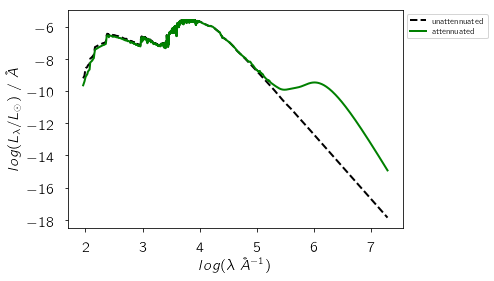

In [90]:
wl = sed[0][:,0]
#unattennuated
us = sed[0][:,2]
#attennuated
us1 = sed[0][:,1]

plt.plot(wl,us, color = 'k',lw = 2.0,linestyle = '--', label = 'unattennuated')
plt.plot(wl,us1, color = 'g',lw = 2.0, label = 'attennuated')
plt.xlabel(r"$log(\lambda$ $\AA^{-1})$", fontsize = 15)
plt.ylabel(r"$log(L_{\lambda}/L_{\odot})$ / $\AA$", fontsize = 15)
plt.legend(loc='upper left', numpoints=1, ncol=1, fontsize=8, bbox_to_anchor=(1, 1))
plt.savefig('magphys_spec.pdf', bbox_inches='tight')
plt.show()



In [91]:
print(min(wl),max(wl), len(wl))

1.959041 7.289812 12816


['wise2010-W1', 'wise2010-W2', 'wise2010-W3', 'wise2010-W4']
34002.54044481694


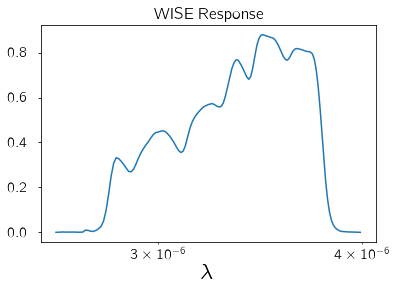

In [94]:
import speclite
from speclite import filters
#boo = speclite.filters

wise = speclite.filters.load_filters('wise2010-*')
print(wise.names)
w1band = speclite.filters.load_filter('wise2010-W1')

wave_w1 = (w1band.wavelength)*(10**(-10))
w1 = w1band.response
#print(w1)
# print(rband(6220))
eff = w1band.effective_wavelength.value
print(eff)

plt.plot(wave_w1,w1)
plt.xscale('log')
plt.xlabel(r'$\lambda$')
plt.title('WISE Response')
plt.show()


# wise = speclite.filters.load_filters('wise2010-*')
# speclite.filters.plot_filters(wise, wavelength_limits=(2, 30),
#     wavelength_unit=astropy.units.micron, wavelength_scale='log')
# plt.gca().set_xticks([2, 5, 10, 20, 30])
# plt.gca().set_xticklabels([2, 5, 10, 20, 30])

In [93]:
# #print(wave_w1)
# wl = np.power(10,np.asarray(sed[1][:,0]))

# #print(wl, len(wl), wl[6400:6700])


# lum = []
# #attennuated
# alum = []

# lum1 = []
# #attennuated
# alum1 = []

# for i in range(len(bins)):
#     wl = np.power(10,np.asarray(sed[i][:,0]))
#     us = np.power(10,np.asarray(sed[i][:,2]))
#     s = np.power(10,np.asarray(sed[i][:,1]))
#     print(len(wl),len(us),len(s))
    
#     #print(np.any(np.diff(wl <= 0)))
#     spec = [wl[j]*s[j] for j in range(len(wl))]
#     uspec = [wl[j]*us[j] for j in range(len(wl))]
#     #print(wl[6400:6700],s[6400:6700])
#     stuff1 = w1band.convolve_with_array(wl[6400:6700],s[6400:6700],photon_weighted=False)
#     ustuff1 = w1band.convolve_with_array(wl,us,photon_weighted=False)
#     stuff = w1band.convolve_with_array(wl,spec,photon_weighted=False)
#     ustuff = w1band.convolve_with_array(wl,uspec,photon_weighted=False)
#     #print(stuff1,ustuff1,stuff,ustuff)
#     #ab = w1band.get_ab_magnitude(s[0:6000])
#     alum.append(stuff)
#     lum.append(ustuff)
#     #maggie.append(ab)
#     alum1.append(stuff1)
#     lum1.append(ustuff1)


